# Ceramic composition study

This notebook is a learning-oriented project.

### Problem definition
This notebook aims at using [MURR Datasets on ceramics and pottery](http://archaeometry.missouri.edu/datasets/datasets.html) through a Data Science pipeline in order to create a model able to derive the source (position and time) of a pottery given its characteristics.

### Data Gathering and Preparation
We may use web scraping in order to get all the available datasets but first we will upload a dataset manually.

### Explorative analysis and Data Enrichment
In order to visualize our data, we may use different techniques :
- Principal Component Analysis
- t-SNE
- K-means clustering to understand if there is already some clusters in our data

### Machine Learning
In order to predict source of a ceramic given its characteristics, we may use different algorithm of classification : 
- Tree Classifier
- Random Forest Classifier
- K-nearest neighbors
- Support Vector Machine
- Neural Networks

### Validation and Testing

### (Maybe) Deployment

## First let's collect the data we will be using

We can do it by scraping the web but as we will only use one file, I will upload it manually.

In case we wanted to scrap the website, we would import few libraries to scrap the datasets and save them in this notebook's folder.


In [1]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

url = "http://archaeometry.missouri.edu/datasets/datasets.html"
response = requests.get(url)
response # 200 means the get operation went through

<Response [200]>

## Explorative Analysis and Data Enrichment
First we import few libraries that will allow us to use our data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

### Load the dataset
We use here the popular python package : pandas for loading the data into the notebook and we preview the DataFrame produced.

In [3]:
ceramic_data = pd.read_excel("Ceramics_of_SA_MURR.xlsx")
ceramic_data.head()

,ANID,Alternate ID,Investigator,Source/Excavator/Museum,Country,State/Province,Site Name,Latitude,Longitude,Material,...,Zr,Al,Ba,Ca,Dy,K,Mn,Na,Ti,V
0,LGD001,NaN,"Burger, Richard","Doyon, Leon",Peru,Cuzco Department,"Machu Picchu, Cave",-13.1633,-72.5456,pottery,...,213.88760,93967.76563,612.53027,12863.56250,7.36059,22413.12500,1051.87939,12482.31738,8389.38086,131.68657
1,LGD002,NaN,"Burger, Richard","Doyon, Leon",Peru,Cuzco Department,"Machu Picchu, Cave",-13.1633,-72.5456,pottery,...,156.45589,116552.26563,1019.36224,13841.52539,3.67417,25755.84180,939.17621,16230.22949,3291.66040,96.67437
2,LGD003,NaN,"Burger, Richard","Doyon, Leon",Peru,Cuzco Department,"Machu Picchu, Cave",-13.1633,-72.5456,pottery,...,140.16945,85954.29688,723.35852,4377.00000,4.51130,55407.29688,348.34689,3667.99854,3524.54370,81.89991
3,LGD004,NaN,"Burger, Richard","Doyon, Leon",Peru,Cuzco Department,"Machu Picchu, Cave",-13.1633,-72.5456,pottery,...,213.65359,109709.35156,552.61023,15309.58203,4.26681,13891.95996,479.97421,16778.72656,5100.54199,82.71318
4,LGD005,NaN,"Burger, Richard","Doyon, Leon",Peru,Cuzco Department,"Machu Picchu, Cave",-13.1633,-72.5456,pottery,...,110.72469,117288.48438,1014.73474,11586.22754,5.08118,35682.93750,912.61285,8554.87500,5128.28174,129.19522


We see in the preview above that the last columns refer to quantitative data about the composition of the sample that may be measured during the sampling. These will definitely serve as covariates. Then we could ask ourselves whether we use the sample site as a covariate too or as a target, whether we want to predict the period or not and whether the vessel form can be considered as a covariate.

### Consideration about the composition
There are 33 composition columns to describe the samples, it is quite a lot and may be reduced for computation reasons to less columns (PCA) if it is useful. Anyway, as the range of values of the different columns are quite different we should standardize these columns.
Improvements to do :
- Separate the columns from the rest of the DataFrame
- Standardize each column
- Look at PCA results

### Consideration about the location
The location can be quite tricky because in a single archaeological there might be multiple sample sites. So we may group the site that are really close to eachother given that we have latitudes and longitudes.
As the discovery of the material is usually located we may not want to use the location as a target but maybe more as a covariate.
Still, before using it as a covariate we should first cluster the data based on its geolocation. We also have to decide what to when geolocation is not given.
You can find an observation of the geolocation data in Tableau in the files.
Improvements to do :
- Clustering algorithm for geolocation
- Taking into account the geolocation
- When taking into account the geolocation we remove some samples from the observation.

### Consideration about the period
Looking at the `Period` column we observe that the periods are not always described the same way, sometimes with typo, interrogation marks, numbers or imprecise data. This column should be cleaned before we can use it.
Concerning the use of this column, we may use it as the target variable as we usually want to know the period of the object that is being discovered.
Improvements to do :
- Cleaning the `Period` column
- Use it as the target

### Consideration about the vessel form
Looking at the `Vessel Form` column we observe that the forms are not always described the same way : there are multiple names for the same object. This column may need some work of NLP before being processed and used as a covariate.
Improvements to do :
- Clean the column

### Cleaning the `Period` Column
First in order to make things easier, we can divide the periods into 3 main :
- Early Period
- Intermediate / Middle Period
- Late Period
To clean the column according to these 3 periods, we will have to :
1. Detect the samples that can be assigned to one of these periods
2. Remove the others
3. Assign a categorical data to the remaining rows

We can note that a row's period can contain "Early Intermediate" or "Late Intermediate" in those case we will apply these rules :
- If the period contains intermediate (or middle) then it is assigned to intermediate
- If the period does not contain intermediate (or middle) and contains either early or late, it will be assigned to early or late

Later when both are mentionned separatedly (as in "Early Intermediate Period/ Early Horizon") we could consider duplicating the row and assigning it to both periods.

This cleaning has been done efficiently in Tableau and we will load the produced dataset in the next cell.

In [4]:
ceramic_period_data = pd.read_csv("ceramic_period_cleaned.csv", sep=";")
ceramic_period_data.head()

,Anid,Al,Alternate ID,As,Ba,Ca,Ce,Co,Context,Country,...,Tb,Th,Ti,U,V,Vessel Form,Ware,Yb,Zn,Zr
0,LGD001,"93967,76563",NaN,"40,98297","612,53027","12863,5625","103,55278","28,14506",NaN,Peru,...,"1,79981","17,38239","8389,38086","3,68916","131,68657",bottle,NaN,"3,65811","127,72469","213,8876"
1,LGD002,"116552,26563",NaN,"10,98282","1019,36224","13841,52539","56,49266","10,77836",NaN,Peru,...,"0,71398","8,50704","3291,6604","2,09256","96,67437",jar,NaN,"2,24933","81,43422","156,45589"
2,LGD003,"85954,29688",NaN,"14,38938","723,35852",4377,"72,42235","8,59488",NaN,Peru,...,"0,78923","13,85785","3524,5437","3,32223","81,89991",plate,NaN,"2,46605","70,55677","140,16945"
3,LGD004,"109709,35156",NaN,"9,85188","552,61023","15309,58203","146,93637","22,35713",NaN,Peru,...,"0,82281","13,53804","5100,54199","3,35973","82,71318",aryballo,NaN,"1,56134","66,01546","213,65359"
4,LGD005,"117288,48438",NaN,"21,59288","1014,73474","11586,22754","80,548","16,53269",NaN,Peru,...,"0,88649","16,3085","5128,28174","3,2906","129,19522",plate,NaN,"2,50693","110,51169","110,72469"


In [5]:
composition_column_list = list(filter(lambda string: len(string) <3, ceramic_period_data.columns))
composition_column_list

['Al',
 'As',
 'Ba',
 'Ca',
 'Ce',
 'Co',
 'Cr',
 'Cs',
 'Dy',
 'Eu',
 'Fe',
 'Hf',
 'K',
 'La',
 'Lu',
 'Mn',
 'Na',
 'Nd',
 'Ni',
 'Rb',
 'Sb',
 'Sc',
 'Sm',
 'Sr',
 'Ta',
 'Tb',
 'Th',
 'Ti',
 'U',
 'V',
 'Yb',
 'Zn',
 'Zr']

In [6]:
column_list_to_keep = composition_column_list + ["Period category"]
ceramic_light_data = ceramic_period_data[column_list_to_keep]
ceramic_light_data.head()

,Al,As,Ba,Ca,Ce,Co,Cr,Cs,Dy,Eu,...,Ta,Tb,Th,Ti,U,V,Yb,Zn,Zr,Period category
0,"93967,76563","40,98297","612,53027","12863,5625","103,55278","28,14506","76,46515","11,56752","7,36059","1,94077",...,"1,69819","1,79981","17,38239","8389,38086","3,68916","131,68657","3,65811","127,72469","213,8876",Autre
1,"116552,26563","10,98282","1019,36224","13841,52539","56,49266","10,77836","17,39297","3,1691","3,67417","1,41591",...,"0,95498","0,71398","8,50704","3291,6604","2,09256","96,67437","2,24933","81,43422","156,45589",Autre
2,"85954,29688","14,38938","723,35852",4377,"72,42235","8,59488","27,98817","9,97703","4,5113","0,99569",...,"1,44149","0,78923","13,85785","3524,5437","3,32223","81,89991","2,46605","70,55677","140,16945",Autre
3,"109709,35156","9,85188","552,61023","15309,58203","146,93637","22,35713","30,15324","9,53466","4,26681","2,00381",...,"1,15499","0,82281","13,53804","5100,54199","3,35973","82,71318","1,56134","66,01546","213,65359",Autre
4,"117288,48438","21,59288","1014,73474","11586,22754","80,548","16,53269","90,25816","17,56713","5,08118","1,39396",...,"1,37539","0,88649","16,3085","5128,28174","3,2906","129,19522","2,50693","110,51169","110,72469",Autre


In [7]:
ceramic_light_data = ceramic_light_data[ceramic_light_data["Period category"] != "Autre"]
ceramic_light_data.head()

,Al,As,Ba,Ca,Ce,Co,Cr,Cs,Dy,Eu,...,Ta,Tb,Th,Ti,U,V,Yb,Zn,Zr,Period category
125,"93423,2891","7,4643","607,8027","17059,7402","63,5395","12,011","18,7602","7,2125","4,7906","1,1088",...,"0,5843","0,7978","17,4371","4296,5771","2,1598","110,1813","3,0336","54,7938","194,8357",early
126,"93414,3359","7,3438","671,3895","16298,7432","61,2202","12,2902","19,1653","7,8122","4,7122","1,1592",...,"0,6013","0,8811","17,3004","3654,4421","3,0085","122,2861","3,1537","52,0528","172,6308",early
127,"84423,4844","10,8596","390,8788","37482,2813","55,1047","14,2489","22,1399","7,3443","4,532","1,085",...,"0,6705","0,7648","13,4766","3063,2561","2,8562","125,4766","2,5652","126,3376","109,2053",intermediate
128,"87287,6484","9,4905","357,7888","21632,9219","58,6566","13,9636","29,2827","7,3577","3,8505","1,0781",...,"0,771","0,6891","12,3608","3825,0659","3,5894","136,7765","2,4609","85,9216","156,606",intermediate
129,"118310,375","12,871","1015,4036","25459,1504","68,5435","6,297","13,6328","6,8262","4,8428","1,6127",...,"0,8105","0,913","19,3818","3285,5417","3,1787","58,0516","2,9675","77,5968","155,6512",intermediate


In [8]:
ceramic_light_data[composition_column_list] = ceramic_light_data[composition_column_list].apply(lambda string: string.str.replace(",",".")).astype(float)
ceramic_light_data.dtypes

Al                 float64
As                 float64
Ba                 float64
Ca                 float64
Ce                 float64
Co                 float64
Cr                 float64
Cs                 float64
Dy                 float64
Eu                 float64
Fe                 float64
Hf                 float64
K                  float64
La                 float64
Lu                 float64
Mn                 float64
Na                 float64
Nd                 float64
Ni                 float64
Rb                 float64
Sb                 float64
Sc                 float64
Sm                 float64
Sr                 float64
Ta                 float64
Tb                 float64
Th                 float64
Ti                 float64
U                  float64
V                  float64
Yb                 float64
Zn                 float64
Zr                 float64
Period category     object
dtype: object

Before using Principal Component Analysis on our data, we will standardize it.

**Careful:** This step has to be reconsidered in the data science pipeline with the issues brought by training and testing sets.

In [9]:
from sklearn.preprocessing import StandardScaler
composition_scaler = StandardScaler()
composition_scaler.fit(ceramic_light_data[composition_column_list])
ceramic_light_data[composition_column_list] = composition_scaler.transform(ceramic_light_data[composition_column_list])

In [10]:
from sklearn.decomposition import PCA
composition_pca = PCA(n_components=2)
composition_pca.fit(ceramic_light_data[composition_column_list])
print(composition_pca.explained_variance_ratio_)
print(composition_pca.components_)

[0.31990551 0.14986018]
[[-0.01799307 -0.04187157 -0.00780192 -0.07000363  0.2807295  -0.13098496
   0.03245132  0.07463393  0.23312459  0.12981114 -0.15722293  0.20431338
   0.18528528  0.28499228  0.22876059 -0.11846972 -0.09149295  0.27344424
   0.08076769  0.21518095  0.0321117  -0.14838944  0.2696277  -0.12104888
   0.22859006  0.20882715  0.25418717 -0.11044715  0.18748812 -0.15642804
   0.2206389  -0.02085577  0.20739357]
 [ 0.20141997  0.05691236 -0.03520164 -0.00410729  0.04816221  0.32194761
   0.07855106 -0.01961032  0.20176604  0.33253801  0.34443621  0.03187426
  -0.11570533  0.02411996  0.16657498  0.22807632 -0.08203977  0.08078586
   0.05397364 -0.0430346  -0.01446135  0.34585519  0.17151647 -0.00934654
  -0.02250521  0.22201113 -0.0719108   0.31420905 -0.08233115  0.2908534
   0.21363674  0.13987935  0.01021055]]


In [11]:
fig = px.scatter(x = composition_pca.components_[0],
           y = composition_pca.components_[1],
           hover_name = composition_column_list)
fig.show()

In [12]:
principal_composition = composition_pca.transform(ceramic_light_data[composition_column_list])
print(principal_composition)

[[ 2.37056374 -1.05899228]
 [ 2.60335359 -0.86050572]
 [ 0.05692726 -1.23002052]
 ...
 [-0.3421455  -2.15560407]
 [-2.68213262 -4.72323859]
 [-3.33410813 -3.67803825]]


In [13]:
import plotly.express as px
fig = px.scatter(
    x = principal_composition[:,0],
    y = principal_composition[:,1],
    color = ceramic_light_data["Period category"]
)
fig.show()

We can see in the figure above that the early period can be separated from late and intermediate visually. However Intermediate and Late periods are quite similar visually from the plot on principal components.

We could try also to visualize the dispersion in the original space via a T-SNE transformation.

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(init = "pca")
tsne_composition = tsne.fit_transform(ceramic_light_data[composition_column_list])
tsne_composition

array([[ 13.70531 , -31.89397 ],
       [ 13.749501, -31.89173 ],
       [ 14.324213,  -8.874304],
       ...,
       [-26.160318, -34.948288],
       [-27.135529, -32.615437],
       [-24.609503, -31.931267]], dtype=float32)

In [15]:
fig = px.scatter(
    x = tsne_composition[:,0],
    y = tsne_composition[:,1],
    color = ceramic_light_data["Period category"],
    hover_data = []
)

fig.show()

In this T-SNE visualisation we can observe the same conclusion for the early period compared to the PCA visualisation.
We observe also similitudes in the positions of intermediate and late periods but we can better separate them here.

## Clustering by geolocation


In [16]:
location_data = ceramic_period_data[["Latitude", "Longitude"]].astype(float)
location_data.isna().any(axis=1).value_counts()

False    4532
True     1431
dtype: int64

In [17]:
location_data = location_data.dropna()

fig = px.scatter_geo(location_data, lat="Latitude", lon="Longitude")
fig.show()

In [18]:
fig = px.scatter(location_data, y="Latitude", x="Longitude")
fig.update_layout(yaxis={"scaleanchor":"x", "scaleratio":1})
fig.show()

Our clustering will be based on an unsupervised algorithm as not all the provinces or states or listed for every samples.

Later, we could choose to consider provinces for those that are listed and countries where provinces or not given but let's first see if an unsupervised algorithm can work well in this case or not.

To cluster by geolocation we can test several algorithms [(here is a list)](https://scikit-learn.org/stable/modules/clustering.html) among this list I choose one of them that seems more appropriate as we do not know in advance the minimum number of samples in each cluster (something we need to know in DBSAN or OPTICS for example).
We could still try DBSCAN to see how it deals with our data.

To evaluate these clustering, we can use different metrics :
- Silhouette Coefficient
- Calinski-Harabasz Index
- Davies-Bouldin Index

These 3 metrics may not all give the same hyper-parameters.
To determine hyper-parameters we can use a Grid Search Cross Validation.

In [19]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from tqdm import tqdm

n_clusters_list = [i for i in range(20,50)]
score_list = []

for n_clusters in tqdm(n_clusters_list):
  geo_kmeans = KMeans(n_clusters = n_clusters).fit(location_data)
  score_list.append(metrics.silhouette_score(location_data, geo_kmeans.labels_, metric='euclidean'))

fig = px.scatter(x=n_clusters_list, y=score_list)
fig.show()

100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


In [20]:
geo_kmeans = KMeans(n_clusters = 32).fit(location_data)
print(metrics.silhouette_score(location_data, geo_kmeans.labels_))
fig = px.scatter_geo(location_data, lat="Latitude", lon="Longitude", color=geo_kmeans.labels_)
fig.show()

0.9082138934576034


In [21]:
from sklearn.cluster import DBSCAN

geo_dbscan = DBSCAN().fit(location_data)

print(metrics.silhouette_score(location_data, geo_dbscan.labels_, metric='euclidean'), max(geo_dbscan.labels_))

fig = px.scatter_geo(location_data, lat="Latitude", lon="Longitude", color=geo_dbscan.labels_)
fig.show()

0.8935964066752121 32


### List of steps for data preparation
1. Remove rows where latitude and longitude are not given
2. Remove rows where Period category is "Autres"
1. Separate training and testing set
2. Keep columns of composition, location and period category
3. Change type of composition columns (Tr/Te)
4. Standardize composition columns (create a StandardScaler) (Train only on training set) (Tr/Te)
5. Train a Principal Component Analysis (Tr)
5. Group samples by location with K-Means (with n_clusters = 32) (create a labeling object) (Train only on training set) (Tr/Te)
6. Remove Latitude and Longitude (Tr/Te)
7. Format location group to categorical (Tr/Te) (location_encoder trained on training set)
8. Format Period Category to categorical (Tr/Te) (period_encoder trained on training set)


In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def prepare_data(ceramic_data, transformers=None):
    """
    Prepare either training set or testing set
    To prepare the testing set, a transformers distionary should be provided with 2 elements :
    - composition_scaler (a StandardScaler object from sklearn)
    - location_kmeans (a KMeans clustering object from sklearn with n_clusters = 32)
    - location_encoder (a OneHotEncoder(categories = list(range(32))) object from sklearn)
    - period_encoder (a OneHotEncoder object from sklearn)
    - composition_pca (a PCA object from sklearn)
    If transformers object is not passed, it will create one considering that the data provided will be used as training set.

    returns:
    data : dataframe of the prepared data
    transformers : either the input object or the created one.
    """
    # 2. Keep columns of composition, location and period category
    composition_column_list = list(
        filter(lambda string: len(string) < 3, ceramic_data.columns))
    column_list_to_keep = composition_column_list + \
        ["Latitude", "Longitude", "Period category"]
    preparing_df = ceramic_data[column_list_to_keep]
    # 3. Change type of composition columns
    preparing_df[composition_column_list] = preparing_df[composition_column_list].apply(
        lambda string: string.str.replace(",", ".")).astype(float)
    if transformers:
        try:
            composition_scaler = transformers["composition_scaler"]
            location_kmeans = transformers["location_kmeans"]
            location_encoder = transformers["location_encoder"]
            period_encoder = transformers["period_encoder"]
        except KeyError:
            print("KeyError : transformers object should contain 'composition_scaler', 'location_kmeans', 'location_encoder' and 'period_encoder' as keys.")
    else:
        composition_scaler = StandardScaler().fit(
            preparing_df[composition_column_list])
        location_kmeans = KMeans(n_clusters=32).fit(
            preparing_df[["Latitude", "Longitude"]])
        new_transformers = {
            "composition_scaler": composition_scaler,
            "location_kmeans": location_kmeans,
        }
    # 4. Standardize composition columns
    preparing_df[composition_column_list] = composition_scaler.transform(
        preparing_df[composition_column_list])
    # 5. Train PCA
    if not(transformers):
        composition_pca = PCA()
        composition_pca.fit(preparing_df[composition_column_list])
        new_transformers["composition_pca"] = composition_pca
    # 5. Group samples by location with K-Means
    preparing_df["Location cluster"] = location_kmeans.predict(
        preparing_df[["Latitude", "Longitude"]])
    # 6. Remove Latitude and Longitude
    preparing_df = preparing_df.drop(
        ["Latitude", "Longitude"], axis="columns")
    if not(transformers):
        location_encoder = LabelBinarizer()
        location_encoder.fit(preparing_df["Location cluster"])
        new_transformers["location_encoder"] = location_encoder
        period_encoder = LabelBinarizer().fit(
            preparing_df["Period category"])
        new_transformers["period_encoder"] = period_encoder
        transformers = new_transformers
    # 7. Format location group to categorical
    location_encoded_column_list = [
        "location_group_"+str(label) for label in location_encoder.classes_]
    location_encoded_df = pd.DataFrame(
        location_encoder.transform(
            preparing_df["Location cluster"]
        ),
        columns=location_encoded_column_list
    )
    preparing_df = preparing_df.reset_index()
    preparing_df = pd.concat(
        [preparing_df, location_encoded_df],
        axis=1)
    preparing_df = preparing_df.drop(columns=["Location cluster"])
    # 8. Format Period Category to categorical
    period_encoded_column_list = period_encoder.classes_
    period_encoded_df = pd.DataFrame(
        period_encoder.transform(preparing_df["Period category"]),
        columns=period_encoded_column_list
    )
    preparing_df = pd.concat(
        [preparing_df, period_encoded_df], axis=1)
    preparing_df = preparing_df.drop(["Period category", "index"], axis=1)
    return preparing_df, transformers
  


In [23]:
from sklearn.model_selection import train_test_split

def prepare_train_test(ceramic_data):
  data = ceramic_data.dropna(subset=["Latitude","Longitude"])
  data = data[data["Period category"] != "Autre"]
  train_data, test_data = train_test_split(data)
  prepared_train_data, ceramic_transformers = prepare_data(train_data)
  prepared_test_data, _ = prepare_data(test_data, transformers= ceramic_transformers)
  return prepared_train_data, prepared_test_data, ceramic_transformers

In [24]:
def replace_composition_with_pca(data, composition_pca, n_components):
    principal_composition_column_list = ["principal_composition_" + str(i+1) for i in range(n_components)]
    principal_composition = pd.DataFrame(
        composition_pca.transform(data[composition_column_list])[:,:n_components],
        columns=principal_composition_column_list
    )
    new_data = pd.concat([data, principal_composition], axis=1)
    new_data = new_data.drop(composition_column_list, axis=1)
    return new_data

def prepare_pca(prepared_train_data, prepared_test_data, ceramic_transformers, n_components=None):
    composition_pca = ceramic_transformers["composition_pca"]
    if not(n_components):
        n_components = len(composition_column_list)
    new_prepared_train = replace_composition_with_pca(prepared_train_data, composition_pca, n_components)
    new_prepared_test = replace_composition_with_pca(prepared_test_data, composition_pca, n_components)
    return new_prepared_train, new_prepared_test

In [25]:
train_data, test_data, transformers = prepare_train_test(ceramic_period_data)
print("Transformers available:", transformers.keys())

Transformers available: dict_keys(['composition_scaler', 'location_kmeans', 'composition_pca', 'location_encoder', 'period_encoder'])


In [26]:
train_data.head()

,Al,As,Ba,Ca,Ce,Co,Cr,Cs,Dy,Eu,...,location_group_25,location_group_26,location_group_27,location_group_28,location_group_29,location_group_30,location_group_31,early,intermediate,late
0,0.355941,-0.272038,-0.143823,-0.142519,-0.459468,1.683225,-0.070887,-0.442312,-0.537825,0.508335,...,0,0,0,0,0,0,0,1,0,0
1,0.596507,-0.337226,-0.428988,-0.478936,0.786377,0.112407,0.097602,0.087423,0.354676,0.213690,...,0,0,0,1,0,0,0,0,0,1
2,-2.156134,-0.783014,-0.651480,-0.008571,-1.563749,-0.306431,0.919590,-0.602992,-1.611135,-1.397464,...,0,0,0,0,0,0,0,0,0,1
3,0.303859,0.033750,0.061411,-0.772918,2.234435,-0.766056,-0.379963,-0.056338,1.048278,0.466914,...,0,0,0,0,0,0,0,0,1,0
4,-0.545495,-0.417915,-2.018959,0.486832,-1.563099,2.563743,-1.074949,-0.682542,-0.769611,1.332061,...,0,0,0,0,0,0,0,1,0,0


There are still a lot of composition columns that may be summarized with the PCA trained during the preparation. We can first take a look at the explained variance.

In [27]:
composition_pca = transformers["composition_pca"]
np.cumsum(composition_pca.explained_variance_ratio_)

array([0.32796102, 0.47793206, 0.55713662, 0.6150669 , 0.66155319,
       0.70366902, 0.73670976, 0.76479864, 0.79177492, 0.81533656,
       0.83709542, 0.85762427, 0.87584005, 0.89201357, 0.90593246,
       0.91762633, 0.92843154, 0.93779585, 0.94633413, 0.95391065,
       0.96124824, 0.96771155, 0.97338313, 0.97829862, 0.98225923,
       0.98583147, 0.9888222 , 0.99162946, 0.99417054, 0.99634002,
       0.99813295, 0.99922777, 1.        ])

In [28]:
input_cols = train_data.columns[:-3]
target_cols = train_data.columns[-3:]
target_cols

Index(['early', 'intermediate', 'late'], dtype='object')

In [29]:
# Split input and target for training end testing sets
X_train = train_data[input_cols]
y_train = train_data[target_cols]
X_test = test_data[input_cols]
y_test = test_data[target_cols]

In [30]:
n_components = 21
train_data_pca, test_data_pca = prepare_pca(train_data, test_data, transformers, n_components)

In [31]:
# Split input and target for training end testing sets
X_pca_train = train_data_pca.drop(target_cols, axis=1)
y_pca_train = train_data_pca[target_cols]
X_pca_test = test_data_pca.drop(target_cols, axis=1)
y_pca_test = test_data_pca[target_cols]

In [32]:
X_no_location_train = train_data[composition_column_list]
y_train = train_data[target_cols]
X_no_location_test = test_data[composition_column_list]
y_test = test_data[target_cols]

In [33]:
def train_test_accuracy(clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    print("Train accuracy:", metrics.accuracy_score(y_train, clf.predict(X_train)))
    print("Test accuracy: ",metrics.accuracy_score(y_test, clf.predict(X_test)))

## Machine Learning

Now that the data has been prepared, we can train some classifiers on it.
List of algorithms we could try:
- Decision Tree
- Random forest
- K-nearest neighbors
- SVM
- Neural Networks

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

### Decision Tree

First, we'll try a decision tree with all the variables.
Then, we'll try a decision tree considering only a subset of the principal components

In [35]:
# Create the instance of Decision Tree Classifier and fit the training data
ceramic_tree_clf = DecisionTreeClassifier(max_depth=6)
ceramic_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [36]:
print("Train accuracy:", metrics.accuracy_score(y_train, ceramic_tree_clf.predict(X_train)))

Train accuracy: 0.9488103821196827


In [37]:
y_pred = ceramic_tree_clf.predict(X_test)
print("Test accuracy: ",metrics.accuracy_score(y_test, ceramic_tree_clf.predict(X_test)))

Test accuracy:  0.937365010799136


Visualize Decision Tree

In [38]:
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

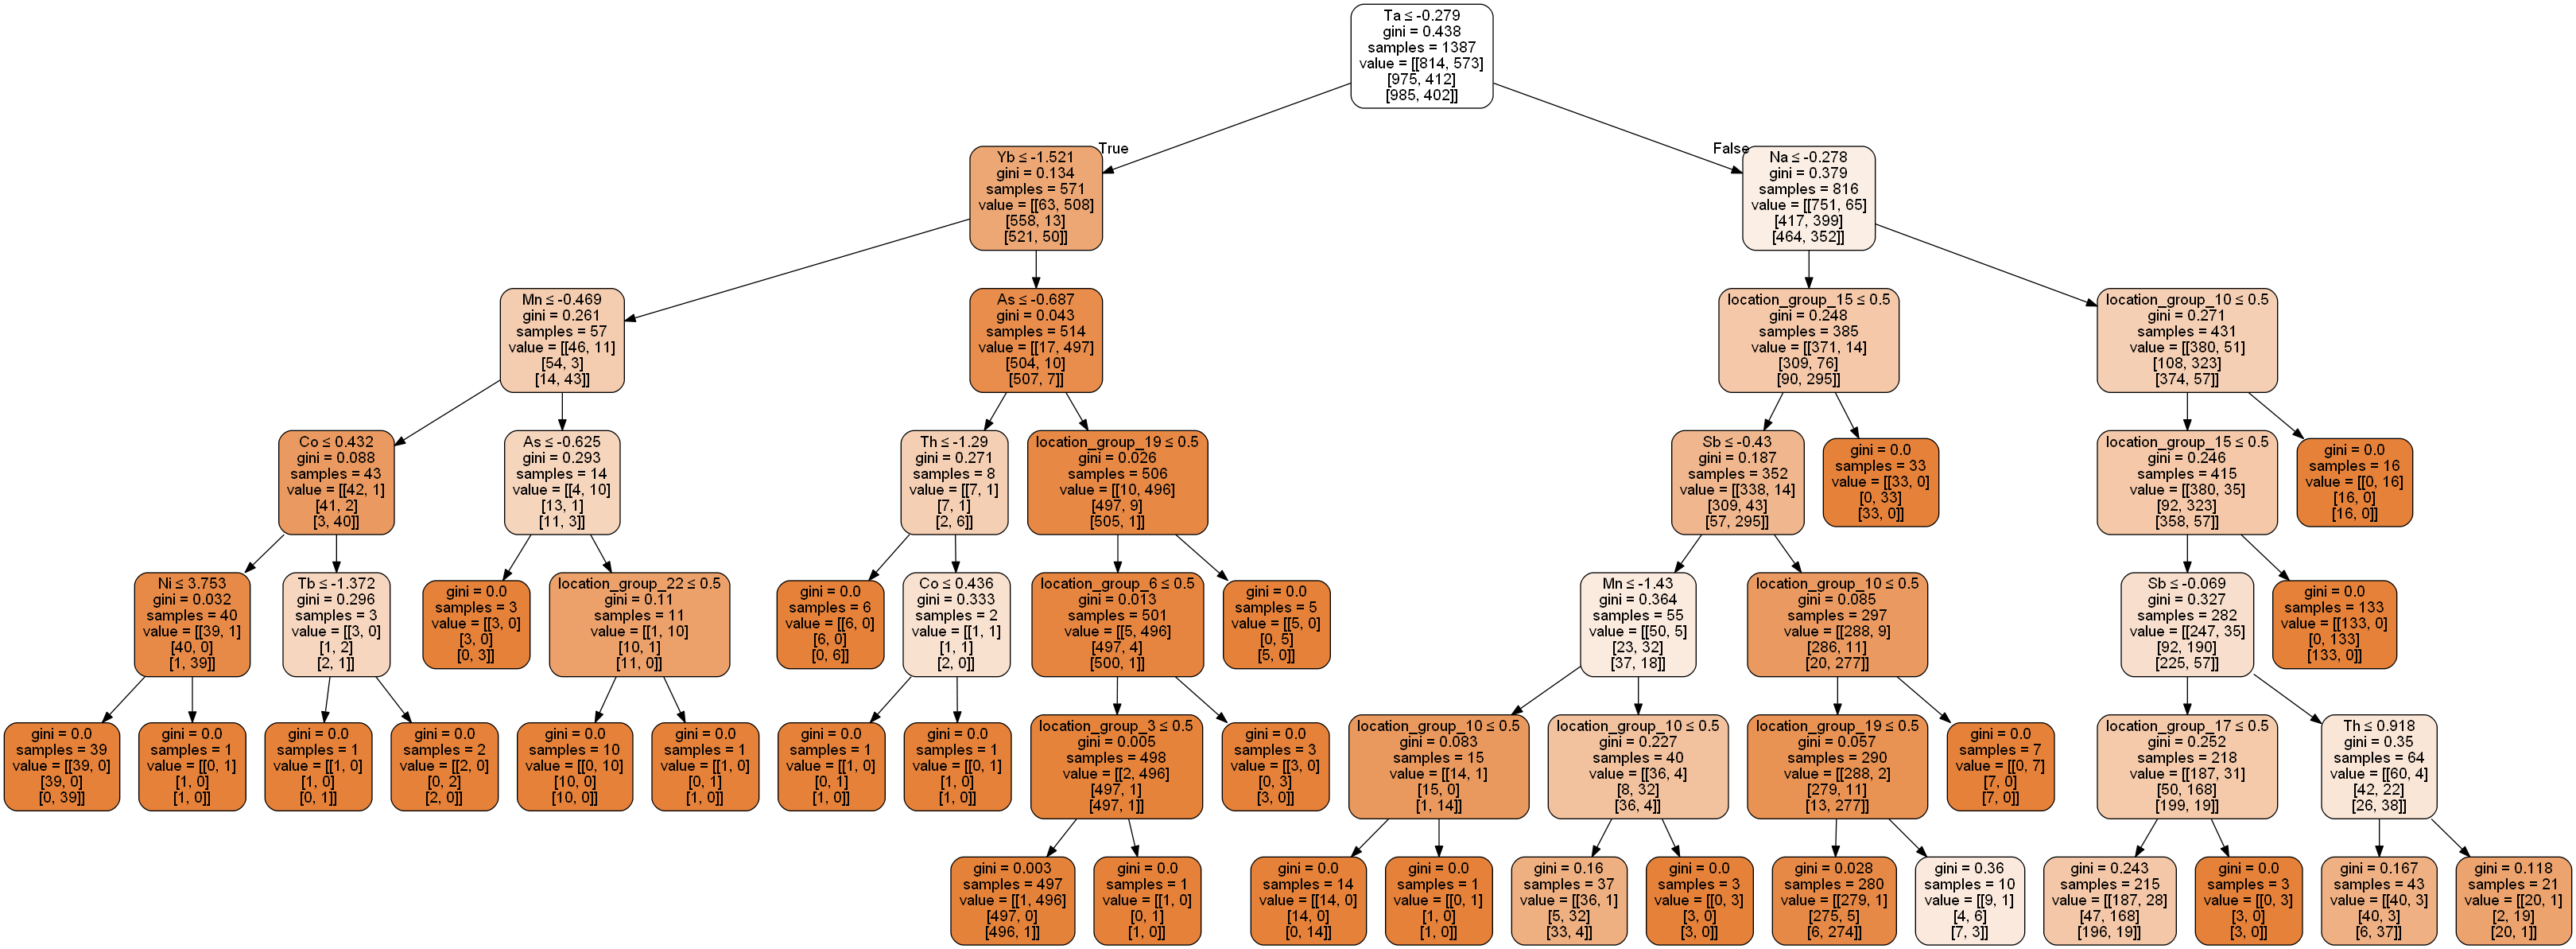

In [39]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(ceramic_tree_clf, out_file=dot_data,
                filled=True, rounded=True, special_characters=True,
                feature_names=input_cols, class_names=target_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("Ceramics_tree1.png")
Image(graph.create_png())

2. A decision tree with principal components

In [40]:
# Create the instance of Decision Tree Classifier and fit the training data
ceramic_tree_pca_clf = DecisionTreeClassifier(max_depth=6)
ceramic_tree_pca_clf.fit(X_pca_train, y_pca_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [41]:
print("Train accuracy:", metrics.accuracy_score(y_pca_train, ceramic_tree_pca_clf.predict(X_pca_train)))
print("Test accuracy: ",metrics.accuracy_score(y_pca_test, ceramic_tree_pca_clf.predict(X_pca_test)))

Train accuracy: 0.8976207642393655
Test accuracy:  0.8704103671706264


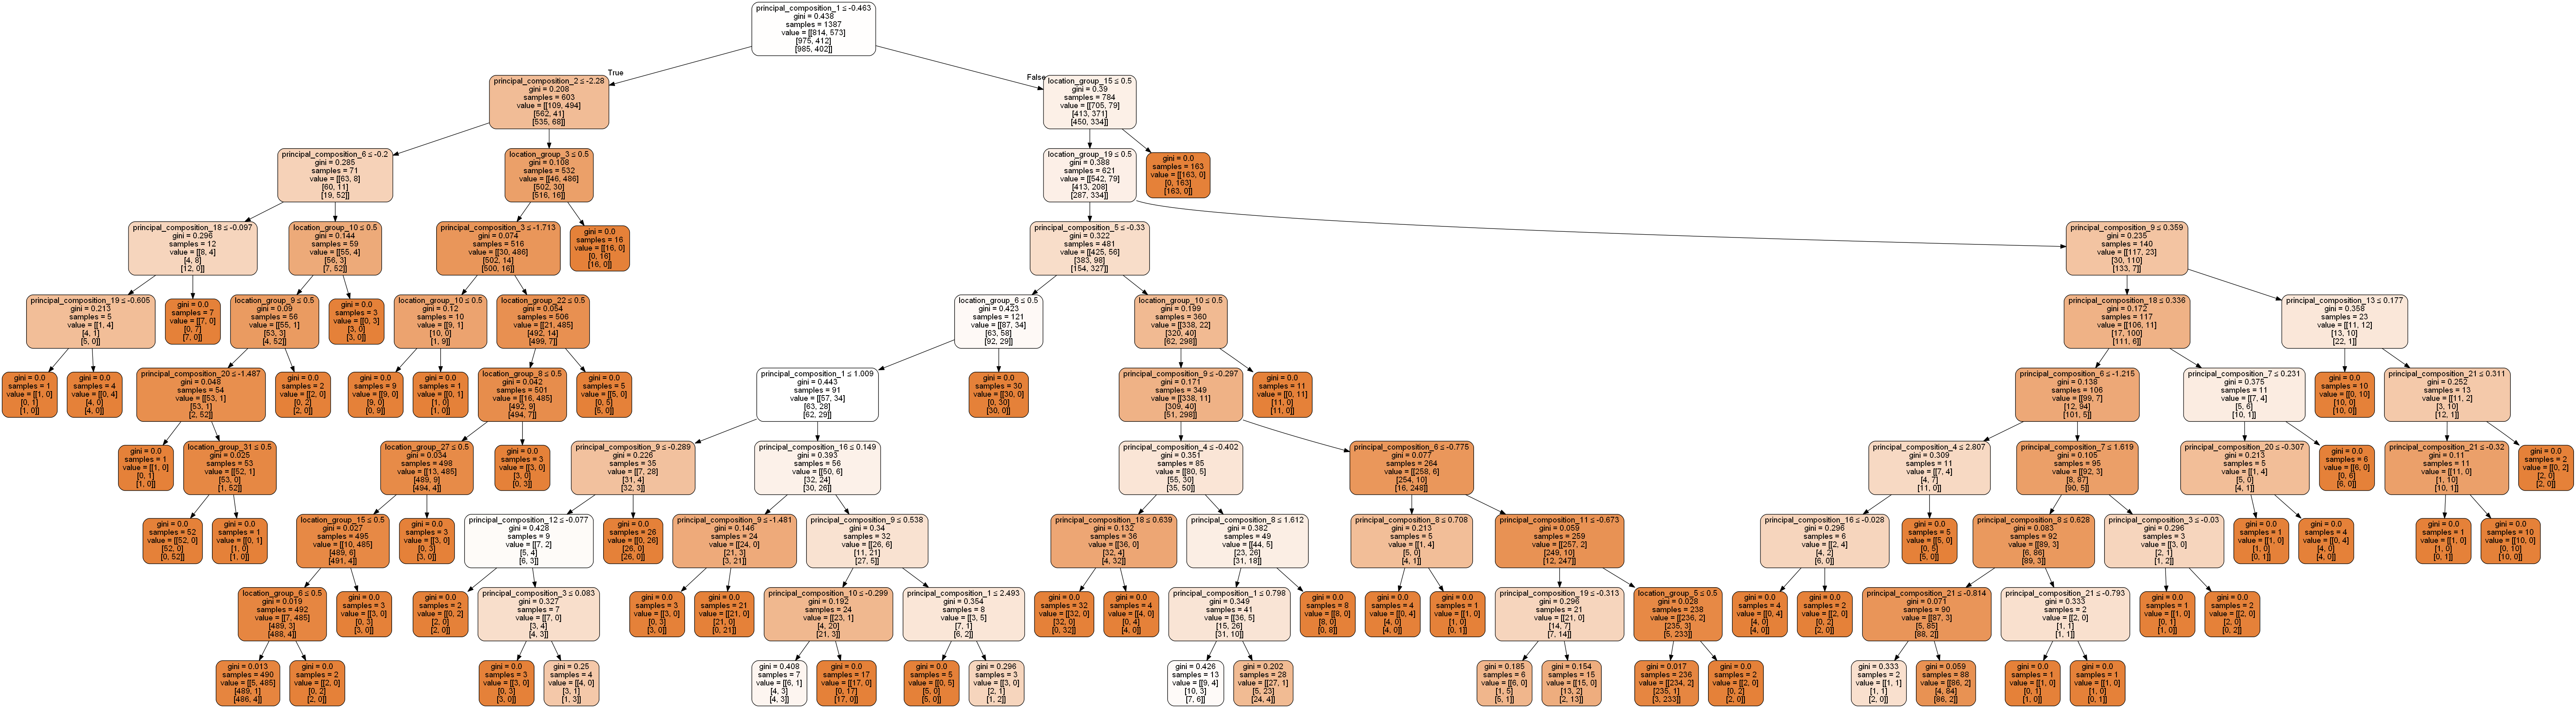

In [43]:
dot_data = StringIO()
export_graphviz(ceramic_tree_pca_clf, out_file=dot_data,
                filled=True, rounded=True, special_characters=True,
                feature_names=X_pca_train.columns, class_names=target_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("Ceramics_tree_pca1.png")
Image(graph.create_png())

Let's compare the results between Decision trees with and without PCA

In [42]:
max_depth_list = list(range(2,10))
accuracy_tree = []
accuracy_tree_pca = []
for max_depth in tqdm(max_depth_list):
    # Decision tree without pca
    ceramic_tree_clf = DecisionTreeClassifier(max_depth=max_depth)
    ceramic_tree_clf.fit(X_train, y_train)
    accuracy_tree.append(metrics.accuracy_score(y_test, ceramic_tree_clf.predict(X_test)))
    # Decision tree with pca
    ceramic_tree_pca_clf = DecisionTreeClassifier(max_depth=max_depth)
    ceramic_tree_pca_clf.fit(X_pca_train, y_pca_train)
    accuracy_tree_pca.append(metrics.accuracy_score(y_pca_test, ceramic_tree_pca_clf.predict(X_pca_test)))
fig = px.scatter(x=max_depth_list,y=accuracy_tree)
fig.add_scatter(x=max_depth_list,y=accuracy_tree_pca, name="pca", mode="markers")

100%|██████████| 8/8 [00:00<00:00, 12.06it/s]


We see clearly in the graph above that we should better not use PCA.

Moreover, we see that a `max_depth` of 6 is quite efficient.

### Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier
ceramic_forest_clf = RandomForestClassifier(max_depth=6)
ceramic_forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
print("Train accuracy:", metrics.accuracy_score(y_train, ceramic_forest_clf.predict(X_train)))
print("Test accuracy: ",metrics.accuracy_score(y_test, ceramic_forest_clf.predict(X_test)))

Train accuracy: 0.9473684210526315
Test accuracy:  0.9244060475161987


What would happen if we did not consider the locations ?

In [46]:
ceramic_tree_no_location_clf = DecisionTreeClassifier(max_depth=6)
ceramic_tree_no_location_clf.fit(X_no_location_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [47]:
print("Train accuracy:", metrics.accuracy_score(y_train, ceramic_tree_no_location_clf.predict(X_no_location_train)))
print("Test accuracy: ",metrics.accuracy_score(y_test, ceramic_tree_no_location_clf.predict(X_no_location_test)))

Train accuracy: 0.9214131218457101
Test accuracy:  0.8855291576673866


The results of the decision tree without help of location is clearly worse.

### K-nearest neighbors
Now, we will use k-nearest neighbors algorithm.

In [48]:
from sklearn.neighbors import KNeighborsClassifier

ceramic_knn_clf = KNeighborsClassifier()
ceramic_knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [49]:
train_test_accuracy(ceramic_knn_clf)

Train accuracy: 0.9473684210526315
Test accuracy:  0.9460043196544277


In [50]:
from tqdm import trange
n_components_list = range(1,34)
n_neighbors_list = range(1,7)
accuracy_knn_pca = []
for n_components in n_components_list:
    for n_neighbors in n_neighbors_list:
        train_data_pca, test_data_pca = prepare_pca(train_data, test_data, transformers, n_components)
        train_data_pca.head()
        # Split input and target for training end testing sets
        X_pca_train = train_data_pca.drop(target_cols, axis=1)
        y_pca_train = train_data_pca[target_cols]
        X_pca_test = test_data_pca.drop(target_cols, axis=1)
        y_pca_test = test_data_pca[target_cols]
        # Train the model
        ceramic_knn_pca_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        ceramic_knn_pca_clf.fit(X_pca_train, y_pca_train)
        # Evaluate the model with metrics accuracy
        y_pred = ceramic_knn_pca_clf.predict(X_pca_test)
        accuracy_knn_pca.append(metrics.accuracy_score(y_pca_test, y_pred))
X = [n_components for n_components in n_components_list for _ in n_neighbors_list]
Y = [n_neighbors for n_components in n_components_list for n_neighbors in n_neighbors_list]
px.scatter_3d(x=X, y=Y, z=accuracy_knn_pca)

Pretty good results are obtained with `n_components=21` and `n_neighbors=3`.

In [51]:
from sklearn.model_selection import GridSearchCV

composition_knn_pca_clf = KNeighborsClassifier()
parameters = {"n_neighbors":list(range(2,50))}

grid_knn_clf = GridSearchCV(composition_knn_pca_clf, parameters)
grid_knn_clf.fit(X_pca_train,y_pca_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [53]:
grid_knn_clf.best_params_

{'n_neighbors': 3}

In [52]:
best_grid_knn = grid_knn_clf.best_estimator_
train_test_accuracy(best_grid_knn, X_pca_train, y_pca_train, X_pca_test, y_pca_test)

Train accuracy: 0.9596250901225667
Test accuracy:  0.9460043196544277


In [54]:
ceramic_knn_no_location_clf = KNeighborsClassifier()
ceramic_knn_no_location_clf.fit(X_no_location_train, y_train)
train_test_accuracy(ceramic_knn_no_location_clf, X_no_location_train, y_train, X_no_location_test, y_test)

Train accuracy: 0.9286229271809661
Test accuracy:  0.9265658747300216


### SVM
1. Linear SVC
2. Polynomial SVC
3. Gaussian RBF SVC

In [55]:
from sklearn.svm import LinearSVC, SVC

SVC only works with 1 column output, so I will "`inverse_transfrom`" the target columns.

In [56]:
period_encoder = transformers["period_encoder"]
y_train_svc = period_encoder.inverse_transform(y_train.to_numpy())
y_test_svc = period_encoder.inverse_transform(y_test.to_numpy())

In [57]:
ceramic_linear_svc = LinearSVC()
ceramic_linear_svc.fit(X_train, y_train_svc)
train_test_accuracy(ceramic_linear_svc, y_train = y_train_svc, y_test = y_test_svc)

Train accuracy: 0.9704397981254506
Test accuracy:  0.9654427645788337


Thanks to the high number of dimensions in our dataset, we achieved our most accurate result so far with the Linear Support Vector Machine Classifier. This high number of dimensions make us think that another kernel for SVC will not lead to better results. This is what we are going to see in the next cells.

In [58]:
ceramic_pca_linear_svc = LinearSVC()
ceramic_pca_linear_svc.fit(X_pca_train, y_train_svc)
train_test_accuracy(ceramic_pca_linear_svc, X_train = X_pca_train, y_train = y_train_svc, X_test=X_pca_test, y_test = y_test_svc)

Train accuracy: 0.9704397981254506
Test accuracy:  0.9654427645788337


In [59]:
ceramic_no_location_linear_svc = LinearSVC()
ceramic_no_location_linear_svc.fit(X_no_location_train, y_train_svc)
train_test_accuracy(ceramic_no_location_linear_svc, X_train = X_no_location_train, y_train = y_train_svc, X_test=X_no_location_test, y_test = y_test_svc)

Train accuracy: 0.9156452775775054
Test accuracy:  0.9244060475161987


Best results have been found with LinearSVC with the original data and the location groups.

In [60]:
ceramic_poly_svc = SVC(kernel="poly", degree=2, coef0=1.0)
ceramic_poly_svc.fit(X_train, y_train_svc)
train_test_accuracy(ceramic_poly_svc, y_train = y_train_svc, y_test = y_test_svc)

Train accuracy: 0.9718817591925017
Test accuracy:  0.9632829373650108


In [61]:
ceramic_rbf_svc = SVC(gamma='auto')
ceramic_rbf_svc.fit(X_train, y_train_svc)
train_test_accuracy(ceramic_rbf_svc, y_train = y_train_svc, y_test = y_test_svc)

Train accuracy: 0.9632299927901946
Test accuracy:  0.9568034557235421


In [62]:
ceramic_sig_svc = SVC(kernel='sigmoid',coef0=1.0)
ceramic_sig_svc.fit(X_train, y_train_svc)
train_test_accuracy(ceramic_sig_svc, y_train = y_train_svc, y_test = y_test_svc)

Train accuracy: 0.6625811103100216
Test accuracy:  0.67170626349892


After the results above we can think that we reached the best score possible.

In [72]:
len(input_cols)

65

In [102]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

ceramic_model = Sequential([
    Dense(64, input_shape = (len(input_cols),), activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(3, activation='sigmoid')
])
ceramic_model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

I put a Dropout in this Sequential model to avoid overfitting as we have few data.

In [103]:
ceramic_model.fit(X_train, y_train, epochs=30)

Epoch 1/30
1387/1387 [==============================] - 0s 116us/step - loss: 0.8946 - accuracy: 0.6662
Epoch 2/30
1387/1387 [==============================] - 0s 50us/step - loss: 0.6922 - accuracy: 0.8075
Epoch 3/30
1387/1387 [==============================] - 0s 48us/step - loss: 0.5517 - accuracy: 0.8522
Epoch 4/30
1387/1387 [==============================] - 0s 51us/step - loss: 0.4620 - accuracy: 0.8738
Epoch 5/30
1387/1387 [==============================] - 0s 44us/step - loss: 0.3969 - accuracy: 0.8839
Epoch 6/30
1387/1387 [==============================] - 0s 49us/step - loss: 0.3633 - accuracy: 0.9012
Epoch 7/30
1387/1387 [==============================] - 0s 46us/step - loss: 0.3114 - accuracy: 0.9164
Epoch 8/30
1387/1387 [==============================] - 0s 45us/step - loss: 0.2825 - accuracy: 0.9120
Epoch 9/30
1387/1387 [==============================] - 0s 50us/step - loss: 0.2542 - accuracy: 0.9293
Epoch 10/30
1387/1387 [==============================] - 0s 45us/step - 

In [104]:
y_test_num = [np.where(classes == 1)[0][0] for classes in y_test.to_numpy()]
y_train_num = [np.where(classes == 1)[0][0] for classes in y_train.to_numpy()]

In [106]:
print("Train accuracy:",metrics.accuracy_score(y_train_num,ceramic_model.predict_classes(X_train)))
print("Test accuracy:",metrics.accuracy_score(y_test_num,ceramic_model.predict_classes(X_test)))
ceramic_model.evaluate(X_test, y_test)

Train accuracy: 0.9733237202595529
Test accuracy: 0.9654427645788337
463/463 [==============================] - 0s 116us/step


[0.1198264977393861, 0.9654427766799927]

Although the neural network achieve pretty accurate results, it does not outperform the LinearSVC, it seems like we have reached the best accuracy with both of these models.

In [112]:
from ann_visualizer.visualize import ann_viz

ann_viz(ceramic_model, filename="ceramic_model.gv", title="Neural Network to predict period of ceramics")